In [5]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/x_ray/labels_x_ray.csv")
with open("../data/strict_bad_files.txt", "r") as f:
    lines = f.readlines()
    bad_files = [l.strip() for l in lines]

filtered_df = df[~df['image_Addr'].isin(bad_files)].drop_duplicates()

datadir = "../data/new_x_ray"
num_classes = 5 
filtered_df[['label_image']] = filtered_df[['label_image']] - 1
img_size = 224
batch_size = 32
target_size = (img_size, img_size)
print(df.columns)
filtered_df['label_image'] = filtered_df['label_image'].apply(str)

train_files, valid_files = train_test_split(filtered_df['image_Addr'],
                                            test_size=0.25,
                                            random_state=2024,
                                            stratify=filtered_df['label_image'])

train_df = filtered_df[filtered_df['image_Addr'].isin(train_files)]
valid_df = filtered_df[filtered_df['image_Addr'].isin(valid_files)]
print(f"Validation Size = {valid_df.shape[0]}, Train Size = {train_df.shape[0]}")

label_decoding = {0: "Dandan", 1: "JomJome", 2: "Sine", 3: "Dast", 4: "Pa"}
model = tf.keras.models.load_model("../model/vgg16-0.96-full_model.h5")

val_datagen = ImageDataGenerator(rescale=1. / 255)
val_generator = val_datagen.flow_from_dataframe(
    valid_df,
    directory=datadir,
    x_col='image_Addr',
    y_col='label_image',
    class_mode='categorical',
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=False
)

Index(['image_Addr', 'label_image'], dtype='object')
Validation Size = 142, Train Size = 424
Found 142 validated image filenames belonging to 5 classes.


4/4 [==============================] - 1s 220ms/step
Accuracy on Test Data: 0.96%
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        27
           1       1.00      0.92      0.96        24
           2       0.97      1.00      0.98        29
           3       1.00      0.96      0.98        25
           4       0.85      1.00      0.92        23

    accuracy                           0.96       128
   macro avg       0.96      0.96      0.96       128
weighted avg       0.97      0.96      0.96       128


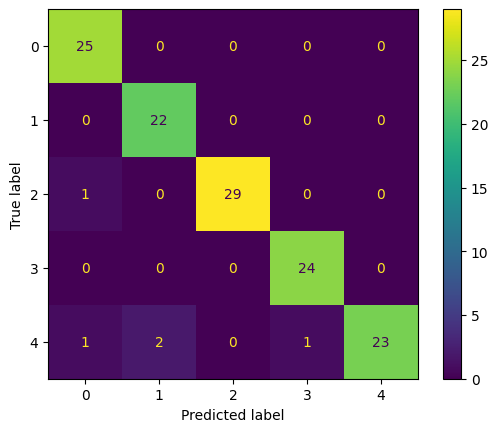

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

preds = model.predict(val_generator,steps = valid_df.shape[0]//batch_size, verbose=1)
predicted_class_indices = np.argmax(preds,axis=1)
labels = valid_df['label_image'][0:len(predicted_class_indices)].apply(int)
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(labels, predicted_class_indices)))
print(classification_report(labels, predicted_class_indices))
cm = confusion_matrix(predicted_class_indices, labels)
ConfusionMatrixDisplay(cm).plot()
plt.show()